## Fill CRUJRA weather over Antartica with data from GSWP3

Will Wieder

Sept 2024

In [1]:
%load_ext autoreload
%autoreload 2

import os
from glob import glob
from os.path import join

import calendar

import tqdm
import cftime
import dask

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.pyplot import cm

from distributed import wait

import warnings
warnings.simplefilter("ignore", category=FutureWarning)

%matplotlib inline

In [2]:
# CRUJRA data
Cfin = '/glade/campaign/cgd/tss/projects/TRENDY2024/inputs/three_stream/'
Cftypes = ['Prec','Solr','TPQWL']
Cdir_in = 'clmforc.CRUJRAv2.5_0.5x0.5.'

# GSWP3 DATA
Gfin = '/glade/campaign/cesm/cesmdata/inputdata/atm/datm7/atm_forcing.datm7.GSWP3.0.5d.v1.c200929/'
Gftypes = ['Precip','Solar','TPHWL']
Gdir_in = 'clmforc.GSWP3.c2011.0.5x0.5.'

vars = ['PRECTmms','FSDS',['TBOT','PSRF','QBOT','WIND','FLDS']]
debug = False

out_dir = '/glade/derecho/scratch/wwieder/TRENDY2024/inputs/three_stream/'
if not os.path.isdir(out_dir):
    os.makedirs(out_dir, exist_ok=True)

v = 0
for Cftype in Cftypes:
    print('starting '+Cftype)
    Gftype = Gftypes[v]
    for year in range(1901, 1921):
        year = str(year)
        print(year)
        # list of files
        Cfiles = []
        Gfiles = []

        Cfiles.extend(sorted(glob(join(Cfin, '*' + Cftype + "." + year + "*.nc"))))
        Gfiles.extend(sorted(glob(join(Gfin, Gftype, '*' + Cftype + "." + year + "*.nc"))))

        Cds = xr.open_mfdataset(Cfiles, decode_times=True, combine='by_coords', parallel=True)
        Gds = xr.open_mfdataset(Gfiles, decode_times=True, combine='by_coords',parallel=True)

        # check that lat-lon dimensions are identical
        if debug == True:
            print(Cfiles)
            print((Gds.LONGXY.isel(time=0) - Cds.LONGXY).min().values)
            print((Gds.LONGXY.isel(time=0) - Cds.LONGXY).max().values)
            print((Gds.LATIXY.isel(time=0) - Cds.LATIXY).min().values)
            print((Gds.LATIXY.isel(time=0) - Cds.LATIXY).max().values)

        # assign missing coords to GSWP3 (this may not be necessary?)
        Gds = Gds.assign_coords({'lon': Cds.lon})
        Gds = Gds.assign_coords({'lat': Cds.lat})

        # Couldn't get interp_like to work as intended, using resample and coarsen instead?
        # just select the nearest values for solar, time mean for others
        if Cftype == 'Solr':
            with dask.config.set(**{'array.slicing.split_large_chunks': False}):
                x = Gds[vars[v]].resample(time="6h").nearest()
        else:
            with dask.config.set(**{'array.slicing.split_large_chunks': False}):
                x = Gds[vars[v]].coarsen(time=2, boundary="trim").mean()
        
        #with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        #    x = Gds.PRECTmms.interp_like(Cds.PRECTmms,method='linear',assume_sorted=False)

        # Create the output dataset where GSWP3 is used south of 60S
        ds_out = Cds.copy('deep')
        ds_out[vars[v]] = xr.where(ds_out.lat < -60, x, ds_out[vars[v]])
        if debug == True:
            ds_out[vars[v]].mean('time').plot(robust=True) ;

        # Write out the new file
        fout = out_dir + Cdir_in + Cftype+"."+year+".nc"
        ds_out.to_netcdf(fout, format="NETCDF4")
        #print('wrote '+fout)

    v = v+1

starting Prec
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
starting Solr
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
starting TPQWL
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920


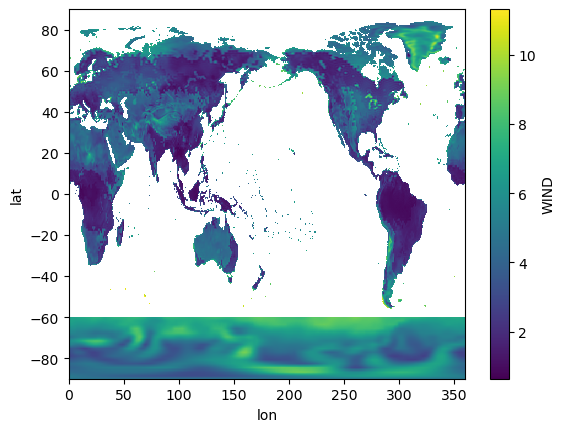

In [3]:
ds_out.WIND.mean('time').plot() ;